# Lab


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


## 1. Chatbot With a Simple Wikipedia Tool

In [4]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_tavily import TavilySearch
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langchain_litellm import ChatLiteLLM
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


@tool
def local_wikipedia(name: str) -> str:
    """
    Returns a string describing Chineidu, a data scientist transitioning into AI Engineering.

    Parameters:
        name (str): The name of the data scientist.

    Returns:
        (str): A string describing the data scientist.
    """
    return (
        f"{name}, AKA Tha-dude, is a data scientist who is transitioning into AI Engineering. "
        "He resides in Lagos State and he's focusing on building and deploying practical AI "
        "solutions relevant to the Nigerian context. He enjoys learning new things and "
        "developing new projects. He is currently working on a project that will help "
        "Nigerians learn how to use AI to solve their problems. "
    )


@tool
def adder(a: float, b: float) -> float:
    """
    Adds two numbers together.

    Parameters:
        a (float): The first number.
        b (float): The second number.

    Returns:
        (float): The sum of the two numbers.
    """
    return a + b


@tool
def multiplier(a: float, b: float) -> float:
    """
    Multiplies two numbers together.

    Parameters:
        a (float): The first number.
        b (float): The second number.

    Returns:
        (float): The product of the two numbers.
    """
    return a * b


@tool
def divider(a: float, b: float) -> float:
    """
    Divides the first number by the second number.

    Parameters:
        a (float): The numerator.
        b (float): The denominator.

    Returns:
        (float): The result of the division.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

In [6]:
async def chatbot(state: State) -> dict[str, Any]:
    """Process chat messages through LLM with tools and return response.

    Parameters
    ----------
    state : State
        Current state containing message history.

    Returns
    -------
    dict[str, Any]
        Dictionary containing LLM response message.
        Contains key 'messages' with list of one message.

    Notes
    -----
    Disables parallel tool calling to prevent duplicate tool invocations
    when restarting the graph flow. Asserts at most one tool call per message.
    """
    system_prompt: str = """
    <role>You're a helpful AI assistant that provides concise answers using logical, 
    step-by-step reasoning. You must always use your tools to answer user queries 
    when applicable, only refraining when a tool cannot be used.</role>
    """
    message = await llm_with_tools.ainvoke([system_prompt] + state["messages"])
    # Disable parallel tool calling because we'll be interrupting (human-in-the-loop)
    # to prevent repeating any tool invocations when we restart the graph
    assert len(message.tool_calls) <= 8
    return {"messages": [message]}


# A simple memory saver for this tutorial. In production,
# it's recommennded to use SqliteSaver or PostgresSaver
memory = MemorySaver()

model_str: str = "mistralai:ministral-8b-latest"  # "mistralai:mistral-large-latest"
llm = init_chat_model(model_str, temperature=0.0)
tavily_search = TavilySearch(max_results=2)
tools = [local_wikipedia, adder, multiplier, divider]
llm_with_tools = llm.bind_tools(tools)

# Add nodes
graph_builder = StateGraph(State)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Connect nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# Add memory, observability and compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph = graph_builder.compile(
    checkpointer=memory
)  # .with_config({"callbacks": [langfuse_handler]})

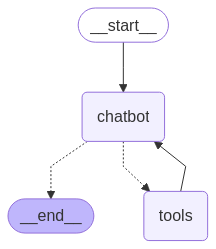

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Prompt The Chatbot

- Prompt the chatbot to lookup when LangGraph was created (`birthday`) and direct the chatbot to reach out to the human_assistance tool once it has the reqired info.
- By setting the `name` and `birthday` in the arguments for the tool, we force the chatbot to generate proposals for these fields.

In [8]:
user_input: str = "Who is Chinedu? What does he do? "
config = {"configurable": {"thread_id": "1"}}

events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

try:
    async for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

except Exception as e:
    console.print(f"Error: {e}")

================================ Human Message =================================

Who is Chinedu? What does he do? 
================================== Ai Message ==================================
Tool Calls:
  local_wikipedia (pmkcv56UH)
 Call ID: pmkcv56UH
  Args:
    name: Chinedu
================================= Tool Message =================================
Name: local_wikipedia

Chinedu, AKA Tha-dude, is a data scientist who is transitioning into AI Engineering. He resides in Lagos State and he's focusing on building and deploying practical AI solutions relevant to the Nigerian context. He enjoys learning new things and developing new projects. He is currently working on a project that will help Nigerians learn how to use AI to solve their problems. 
================================== Ai Message ==================================

Chinedu is a data scientist transitioning into AI Engineering. He is based in Lagos State and is focused on building and deploying practical AI soluti

In [9]:
user_input: str = "What is 7 plus 3? Divide the result by 4"

events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

try:
    async for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

except Exception as e:
    console.print(f"Error: {e}")

================================ Human Message =================================

What is 7 plus 3? Divide the result by 4
================================== Ai Message ==================================
Tool Calls:
  adder (39oEfH6p9)
 Call ID: 39oEfH6p9
  Args:
    a: 7
    b: 3
  divider (xsM5zdtxi)
 Call ID: xsM5zdtxi
  Args:
    a: 10
    b: 4
================================= Tool Message =================================
Name: divider

2.5
================================== Ai Message ==================================

The result of 7 plus 3 is 10. Dividing this result by 4 gives 2.5.


## State Reducers

- Multiple messages can be concatenated using: 
  - Using operator.add
  - Using langgraph's add_message function

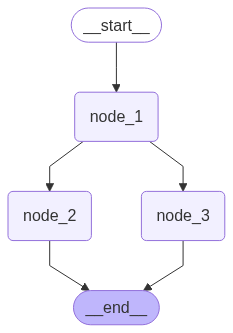

In [10]:
from operator import add


class DefaultState(TypedDict):
    messages: list


class StateWithOperatorAdd(TypedDict):
    messages: Annotated[list, add]


class StateWithAddMessages(TypedDict):
    messages: Annotated[list, add_messages]


def node_1(state: DefaultState) -> dict[str, Any]:
    print("node 1")
    return {"messages": state["messages"]}


def node_2(state: DefaultState) -> dict[str, Any]:
    print("node 2")
    return {"messages": ["processed"]}


def node_3(state: DefaultState) -> dict[str, Any]:
    print("node 3")
    return {"messages": ["processed"]}


graph_builder = StateGraph(DefaultState)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

<br>

### Comment

- When we use the `DefaultState` as the state type, there's no way to concatenate the messages, we get an error because multiple steps/nodes can't write to the same field at the same time.
- To solve this, we can use `StateWithOperatorAdd` or `StateWithAddMessages`

In [11]:
from langgraph.errors import InvalidUpdateError

try:
    result = graph.invoke({"messages": ["Hello"]})
    pprint(result)
except InvalidUpdateError as e:
    console.log(f"Error: {e}")

node 1
node 2
node 3


[21:11:46] Error: At key 'messages': Can receive only one value per step. Use an Annotated key to   ]8;id=485685;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3042397884.py\3042397884.py]8;;\:]8;id=885527;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3042397884.py#7\7]8;;\
           handle multiple values.                                                                                 
           For troubleshooting, visit:                                                                             
           https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE                

In [12]:
# how add_messages works.
initial_message: list[Any] = [
    {"role": "user", "content": "Hello"},
    {"role": "assistant", "content": "Hi there!"},
]

# Add new message
new_message: dict[str, Any] = {"role": "user", "content": "How are you?"}

# Use add_messages to create a new list with the new message added
add_messages_result: list[Any] = add_messages(initial_message, new_message)
console.log(f"Result of add_messages: {add_messages_result}")

[21:11:47] Result of add_messages: [HumanMessage(content='Hello', additional_kwargs={},            ]8;id=665030;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/2283970116.py\2283970116.py]8;;\:]8;id=40000;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/2283970116.py#12\12]8;;\
           response_metadata={}, id='9e3ab599-a1bd-4a83-ba7c-16f6e47704b9'), AIMessage(content='Hi                 
           there!', additional_kwargs={}, response_metadata={},                                                    
           id='a7e271aa-feab-47bb-993c-dd83a07b42e2'), HumanMessage(content='How are you?',                        
           additional_kwargs={}, response_metadata={}, id='3a42c37f-17d2-4b8f-a50b-3d175cf9518a')]                 

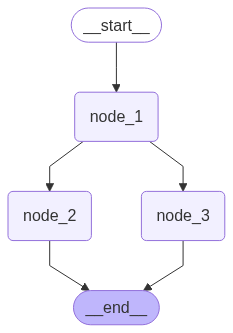

In [13]:
def node_1(state: StateWithOperatorAdd) -> dict[str, Any]:
    print("node 1")
    return {"messages": state["messages"]}


def node_2(state: StateWithOperatorAdd) -> dict[str, Any]:
    print("node 2")
    return {"messages": ["processed"]}


def node_3(state: StateWithOperatorAdd) -> dict[str, Any]:
    print("node 3")
    return {"messages": ["processed"]}


graph_builder = StateGraph(StateWithOperatorAdd)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
try:
    result = graph.invoke({"messages": ["Hello"]})
    pprint(result)
except InvalidUpdateError as e:
    console.log(f"Error: {e}")

node 1
node 2
node 3
{'messages': ['Hello', 'Hello', 'processed', 'processed']}


In [15]:
try:
    result = graph.invoke({"messages": None})
    pprint(result)
except (InvalidUpdateError, TypeError) as e:
    console.log(f"Error: {e}")

[21:11:52] Error: can only concatenate list (not "NoneType") to list                                 ]8;id=843668;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/819682595.py\819682595.py]8;;\:]8;id=836733;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/819682595.py#5\5]8;;\

### Custom Reducers

- We can create custom reducers for handlng edge cases.

In [16]:
def reduce_list(left: list[list[Any]] | None, right: list[Any] | None) -> list[Any]:
    """Reduce two lists into one."""
    if left is None:
        left = []
    if right is None:
        right = []
    return left + right

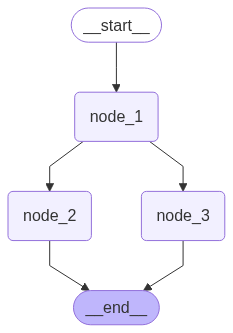

In [17]:
class StateWithCustomReducer(TypedDict):
    messages: Annotated[list, reduce_list]


def node_1(state: StateWithCustomReducer) -> dict[str, Any]:
    print("node 1")
    return {"messages": state["messages"]}


def node_2(state: StateWithCustomReducer) -> dict[str, Any]:
    print("node 2")
    return {"messages": ["processed"]}


def node_3(state: StateWithCustomReducer) -> dict[str, Any]:
    print("node 3")
    return {"messages": ["processed"]}


graph_builder = StateGraph(StateWithCustomReducer)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
try:
    result = graph.invoke({"messages": None})
    pprint(result)
except (InvalidUpdateError, TypeError) as e:
    console.log(f"Error: {e}")

node 1
node 2
node 3
{'messages': ['processed', 'processed']}


<hr><br>

## Multiple Schemas

- We can use specific schemas for the input and output of the graph.
- This can be based on the relevant keys in the input and output.

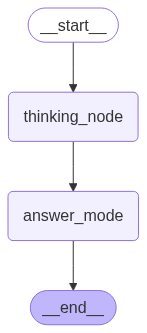

In [19]:
class InputState(TypedDict):
    question: str


class OutputState(TypedDict):
    answer: str


class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: InputState) -> dict[str, str]:
    return {"answer": "bye", "notes": "... his name is Neidu"}


def answer_mode(state: OverallState) -> OutputState:
    return {"answer": "bye Neidu"}


# Build the state graph
graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)
graph_builder.add_node("thinking_node", thinking_node)
graph_builder.add_node("answer_mode", answer_mode)

# Connect nodes
graph_builder.add_edge(START, "thinking_node")
graph_builder.add_edge("thinking_node", "answer_mode")
graph_builder.add_edge("answer_mode", END)

# Compile the graph and visualize it
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "What is your name?"})
pprint(result)

{'answer': 'bye Neidu'}


<hr><br>


## Filtering And Trimming Messages

- To avoid sending too many messages to the LLM especially as the context grows, we can filter and trim the messages.

### 1. Using A Reducer To Remove Messages
- Using `add_messages`  and `RemoveMessage`
- This modifies the graph's state.

#### Observability

- You can view the traces using `LangFuse` or any other observability tool.

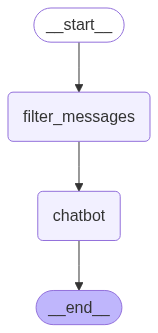

In [33]:
from langchain_core.messages import RemoveMessage


class MessageState(TypedDict):
    messages: Annotated[list[Any], add_messages]


def filter_messages(state: MessageState) -> dict[str, Any]:
    # Delete all but the N most recent messages
    N: int = 3
    deleted_messages: list[Any] = [
        RemoveMessage(id=m.id) for m in state["messages"][:-N]
    ]
    return {"messages": deleted_messages}


async def chatbot(state: MessageState) -> dict[str, Any]:
    response = await llm.ainvoke(state["messages"])
    return {"messages": [response]}


# Build the state graph
graph_builder = StateGraph(MessageState)

# Add Nodes
graph_builder.add_node("filter_messages", filter_messages)
graph_builder.add_node("chatbot", chatbot)

# Connect nodes
graph_builder.add_edge(START, "filter_messages")
graph_builder.add_edge("filter_messages", "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph and visualize it
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
config = {"configurable": {"thread_id": "1"}}
messages: list[Any] = [
    {"role": "user", "content": "Hi!"},
    {"role": "assistant", "content": "Hello"},
    {"role": "user", "content": "I'm Chinedu."},
    {"role": "assistant", "content": "Hello, how can I help you today?"},
    {"role": "user", "content": "can you remember my name?"},
]

async for message in graph.astream(
    {"messages": messages}, config=config, stream_mode="values"
):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

can you remember my name?
================================ Human Message =================================

can you remember my name?
================================== Ai Message ==================================

Yes, I can remember your name. You are Chinedu. How can I assist you today?


In [32]:
message

{'messages': [AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, id='8920da96-a643-4b08-91cb-e1514e536a08'),
  HumanMessage(content='can you remember my name?', additional_kwargs={}, response_metadata={}, id='8f58e3e9-20ab-4015-aee9-b552a60653c5'),
  AIMessage(content="I don't have the ability to remember or store personal information between interactions. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 21, 'total_tokens': 44, 'completion_tokens': 23}, 'model_name': 'ministral-8b-latest', 'model': 'ministral-8b-latest', 'finish_reason': 'stop'}, id='run--072aa728-6d2b-4659-a0d4-3b7056b1c988-0', usage_metadata={'input_tokens': 21, 'output_tokens': 23, 'total_tokens': 44})]}

<br>

### 2. Filtering Messages Without Modifying The Graph's State

- This can be done by selecting a slice of the message history.
- i.e. `state["messages"][-N:]`

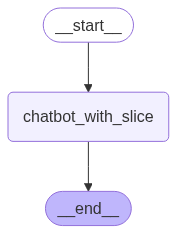

In [35]:
async def chatbot_with_slice(state: MessageState) -> dict[str, Any]:
    N: int = 3
    response = await llm.ainvoke(state["messages"][-N:])
    return {"messages": [response]}


# Build the state graph
graph_builder = StateGraph(MessageState)

# Add Nodes
graph_builder.add_node("chatbot_with_slice", chatbot_with_slice)

# Connect nodes
graph_builder.add_edge(START, "chatbot_with_slice")
graph_builder.add_edge("chatbot_with_slice", END)

# Compile the graph and visualize it
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
config = {"configurable": {"thread_id": "1"}}
messages: list[Any] = [
    {"role": "user", "content": "Hi!"},
    {"role": "assistant", "content": "Hello"},
    {"role": "user", "content": "I'm Chinedu."},
    {"role": "assistant", "content": "Hello, how can I help you today?"},
    {"role": "user", "content": "can you remember my name?"},
]

async for message in graph.astream(
    {"messages": messages}, config=config, stream_mode="values"
):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

can you remember my name?
================================== Ai Message ==================================

Yes, I can remember your name. You are Chinedu. How can I assist you today?
